
# Семинар 8 - Алгоритмы анализа стереопар изображений

***

Полезные материалы:

- [First Principles of Computer Vision - Camera Calibration | Uncalibrated Stereo](https://youtube.com/playlist?list=PL2zRqk16wsdoCCLpou-dGo7QQNks1Ppzo&si=iXEBEehuQr-IgIVC) - плейлист с серией лекций по калибровке камеры и стереозрению
- [Simple Stereo | Camera Calibration](https://youtu.be/hUVyDabn1Mg?si=HmalQZKI9ytoyxPn) - лекция из плейлиста выше, в которой доступно раскрывается тема данного семинара

На этом семинаре будет разобрана тема стереозрения, которая заключается в применении нескольких видов камер для получения информации о глубине обзора. Используя стереозрение, можно определить местоположение точки в мире по ее изображениям в разных ракурсах камеры.

Термин охватывает многие приложения, работающие с несколькими видами отслеживаемого объекта под разными углами. Это могут быть стереокамеры, которые имеют несколько камер на одних и тех же устройствах, или разные виды с разных устройств.

1. **3D реконструкция с нескольких ракурсов**: знаем параметры калибровки каждой из камер, необходимо найти положение 3D объекта в мировых координатах.

2. **Оценка на основе движения (Structure From Motion)**: не знаем параметры калибровки, необходимо одновременно восстановить и координаты, и калибровку.

Первая задача проще в своей постановке, рассмотрим ее.

## Моно/Стерео зрение

_Источник изображений: https://github.com/polygon-software/python-visual-odometry_

![1_projection_and_stereo](data/1_projection_and_stereo.png)

**Идея:** можем найти пересечение лучей, исходящих из разных камер, и по параметрам камеры определить расстояние до объекта. Вы можете ощутить эффект стереовидения на основе своих глаз. Поставьте палец перед глазами. Закройте один глаз, потом другой глаз. Вы заметите, что пальцы, кажется, прыгают слева направо. Это наблюдаемое горизонтальное смещение называется диспаратностью (расхождением, disparity).

![3_stereo_cases](data/3_stereo_cases.png)

Рассмотрим более простой случай с выровненными (ректифицированными) камерами.

![4_stereo_vision_simple](data/4_stereo_vision_simple.png)

## Вопрос 1 

Зная $f$ (фокальное расстояние камер), $b$ (расстояние между камерами), $u_l$, $u_r$, определить расстояние до объекта $Z_{p}$.

**Ответ:**
Чтобы найти расстояние до объекта $Z_{p}$, используется формула из геометрии стереозрения, которая связывает фокусное расстояние f, базовое расстояние между камерами b, и диспаратность d=$u_l$ - $u_r$ (горизонтальное смещение между соответствующими точками на левом и правом изображениях):
$Z_{p}$=(f*b)/d

## Расчет диспаратности с помощью OpenCV

In [1]:
!wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_l.png -O data/tsukuba_l.png
!wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_r.png -O data/tsukuba_r.png

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


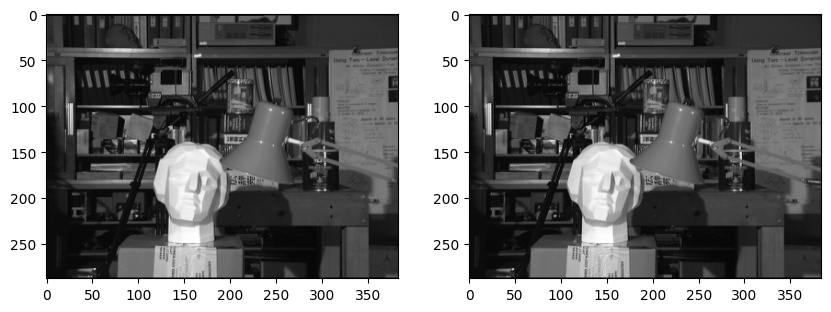

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgL = cv2.imread('data/tsukuba_l.png',0)
imgR = cv2.imread('data/tsukuba_r.png',0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(imgL, cmap="gray")
ax[1].imshow(imgR, cmap="gray")

### cv2.StereoBM_create

https://docs.opencv.org/4.5.0/d9/dba/classcv_1_1StereoBM.html#a04fdf00525f82fe708d556e2cd359004

Чем меньше `blockSize` - тем детальнее карта диспаратности, однако и количество шума растет.

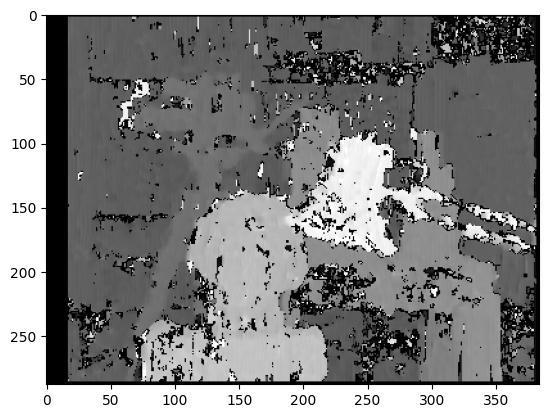

In [3]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=5,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

При слишком больших значениях `blockSize` шум отсутствует, однако детализация крайне низка:

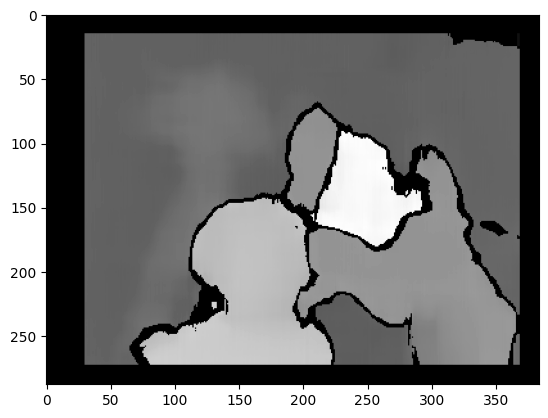

In [4]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=31,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

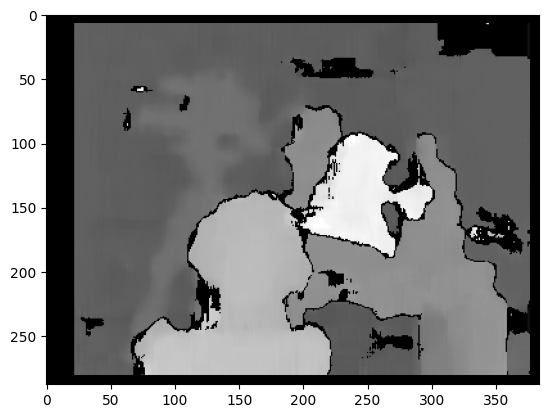

In [5]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=15,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

## Задание 1 - реализация алгоритма расчета диспаратности

Рассмотрим базовый жадный алгоритм наилучшего соответсвия (winner takes all, WTA) между изображениями с помощью блоков и метрики близости (sum of absolute difference, SAD).

![alg](data/alg.png)

**Заполните пропуски в коде**

In [8]:
def compare_blocks(
    block_left: np.array,
    block_right: np.array,
) -> float:
    '''
    Takes blocks from left/right image
    and return similarity metric (for example, sum of absolute differences)
    '''

    # SAD is the sum of absolute differences of intensities
    metric = np.sum(np.abs(block_left - block_right))

    return metric


def get_disparity(
    imgL: np.array,  # (H, W) Grayscale
    imgR: np.array,  # (H, W) Grayscale
    numDisparities: int,  # the same in opencv
    blockSize: int,  # the same in opencv
) -> np.array:

    assert imgL.shape == imgR.shape, 'Images are not equal'

    H, W = imgL.shape
    disparity_map = np.zeros_like(imgL)  # (H, W)

    for i in range(H):
        for j in range(W):

            # define base block to compare
            # using blockSize and i, j

            half_block = blockSize // 2
            row_min = max(0, i - half_block)
            row_max = min(H, i + half_block + 1)
            col_min = max(0, j - half_block)
            col_max = min(W, j + half_block + 1)
            block_left = imgL[row_min:row_max, col_min:col_max]
            metrics = []

            for k in range(1, numDisparities):

                # define secondary block to compare
                # using blockSize and i, j

                col_min_r = max(0, j - k - half_block)
                col_max_r = min(W, j - k + half_block + 1)
                block_right = imgR[row_min:row_max, col_min_r:col_max_r]

                # metrics.append(
                #     compare_blocks(
                #       block_left,
                #       block_right
                #     )
                # )
                 # Если блок выходит за границы изображения, мы его не сравниваем
                if block_left.shape == block_right.shape:
                    metrics.append(compare_blocks(block_left, block_right))
                else:
                    metrics.append(float('inf'))  # Максимальное значение для невозможного сопоставления


            # Выбор индекса с наименьшей метрикой
            best_index = np.argmin(metrics)
            # Конвертация индекса в диспаратность
            if metrics[best_index] != float('inf'):
                disparity_map[i, j] = best_index
            else:
                disparity_map[i, j] = 0

    return disparity_map

## Вопрос 2

Заполняет ли алгоритм все пиксели глубины? Как можно улучшить его? (Например, рассмотрите вариант, когда `metrics.min()` выдает большое число, что делать в этом случае? Или предложите свою версию.)

**Ответ:**
Нет, алгоритм не заполняет все пиксели глубины, особенно на границах изображения и в областях, где невозможно найти соответствие из-за недостатка текстуры или окклюзии (перекрытия). Если metrics.min() выдает большое число, это может указывать на то, что ни одно соответствие не найдено и диспаратность не может быть определена надежно. В таких случаях можно присвоить пикселю значение, которое явно указывает на отсутствие данных, например, np.nan (не число) или максимально возможное значение диспаратности для того чтобы обозначить, что глубина неизвестна.

Для улучшения алгоритма можно рассмотреть эти подходы:

Постобработка: Применить фильтрацию к карте диспаратности для сглаживания и устранения выбросов.
Использование других метрик: Перейти с SAD на более сложные метрики, такие как (SSD) сумма квадратов разностей или NCC (нормализованный кросс-корреляционный коэффициент), которые могут быть более устойчивы к шуму.

## Задание 2

Сравните свою реализацию с opencv StereoBM с помощью попиксельного сравнения карт диспаратности.

In [9]:
import cv2
from sklearn.metrics import mean_squared_error

# Загруз изображения
imgL = cv2.imread('data/tsukuba_l.png', 0)
imgR = cv2.imread('data/tsukuba_r.png', 0)

# Получение карты диспаратности с помощью вашего алгоритма
disparity_map_custom = get_disparity(imgL, imgR, numDisparities=16, blockSize=15)

# Создание объекта StereoBM и вычисление карты диспаратности с помощью OpenCV
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity_map_opencv = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# Подготовка карт диспаратности для сравнения (нормализация к одинаковому масштабу)

disparity_map_opencv[disparity_map_opencv < 0] = 0

# Сравнение карт с помощью MSE
mse = mean_squared_error(disparity_map_custom, disparity_map_opencv)

# Вывод результатов сравнения
print(f"Среднеквадратическая ошибка (MSE) между картами: {mse}")


Среднеквадратическая ошибка (MSE) между картами: 27.830339431762695


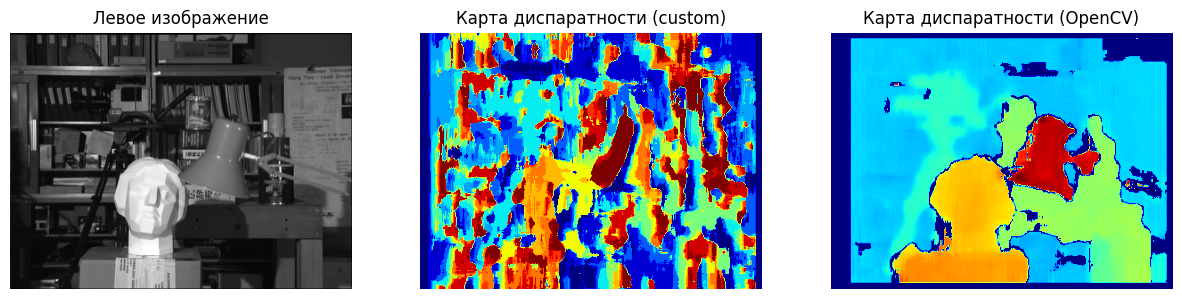

In [10]:
import matplotlib.pyplot as plt

disparity_map_custom_vis = cv2.normalize(disparity_map_custom, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_map_opencv_vis = cv2.normalize(disparity_map_opencv, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Визуализация карт
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(imgL, cmap='gray')
axes[0].set_title('Левое изображение')
axes[0].axis('off')

axes[1].imshow(disparity_map_custom_vis, cmap='jet')
axes[1].set_title('Карта диспаратности (custom)')
axes[1].axis('off')

axes[2].imshow(disparity_map_opencv_vis, cmap='jet')
axes[2].set_title('Карта диспаратности (OpenCV)')
axes[2].axis('off')

plt.show()



## Вопрос 3

Как еще с помощью пройденных классических алгоритмов можно построить карту диспаратности? Приведите краткое описание придуманного/существующего алгоритма.

**Ответ:**

Карту диспаратности также можно построить с помощью следующих классических алгоритмов:

Метод динамического программирования: Подход, в котором поиск соответствий между строками пикселей изображений рассматривается как задача оптимизации. Алгоритм последовательно выбирает оптимальные соответствия, минимизируя заранее определенную стоимость несоответствия.

Алгоритмы на основе глобальной оптимизации (например, Graph Cuts): Задача поиска карты диспаратности формулируется как задача минимизации энергии. Веса в графе отражают стоимость присваивания диспаратности, и оптимальное решение находится путем минимизации этой энергии на всем изображении.

Семи-глобальное блочное сопоставление (Semi-Global Matching, SGM): Этот метод объединяет локальные методы сопоставления с глобальными оптимизационными процессами. Он вычисляет диспаратность, минимизируя стоимость не только в одном направлении, но и в нескольких направлениях на изображении.